# Importing Libraries

In [1]:
# importing dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Step - I

## Cloning and Building Darkent:

We are cloning the Darknet into uor VM and enabling the OPENCV and GPU for Darknet (i.e; making OPENCV and GPU to 1 from 0), verfying whether cuda is present in our VM and !make is used in building the Darknet and all the dependencies.

In [2]:
# Cloning the Git Repo to get the darknet
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


In [3]:
# changing makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [4]:
# Verfying whether CUDA is on our VM or not
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
# Building the Darknet
!make

# Step-2
## Download pretrained YOLOv3 weights
YOLOv3 has been trained on coco dataset which has 80 classes that it can predict. So, this model has already been trained on the dataset and now we are loading the weigths on the YOLOv3 model.

### Transfer Learning:
This is a concept called Transfer Learning in which we take already pretrained model and use those weights and architechture and try to predict for our data. Because training takes a lot of time and also takes a lot of compute. So, many people can't effort to train these big models. So, big companies and universities train these and keep them opensource. We can use them for our usecase.

In [6]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-10-06 22:00:10--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  17.3MB/s    in 15s     

2022-10-06 22:00:26 (16.1 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



In [7]:
# Now we are defining some helper functions to show images, upload files and to download files to our VM.

def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# Step-3
## Testing the model:

Darknet is now built and ready to detect the objects using YOLOv3.

The Darknet already comes with some images like; person, dog, horses etc. If we want some extra images then we need to upload those images in the data folder. I have uploaded the traffic image in the data folder to check its prediction.

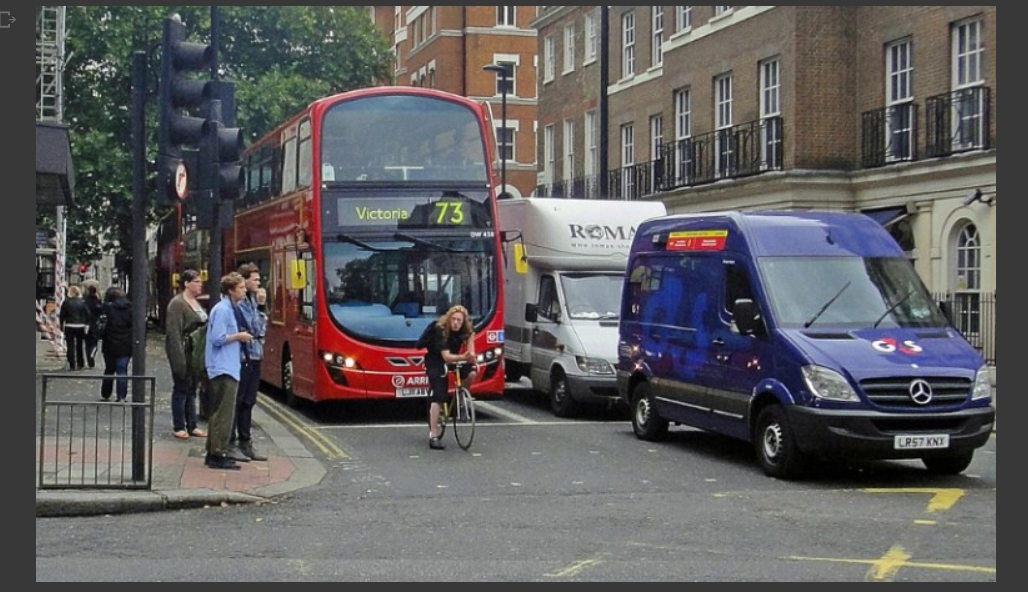

In [41]:
img = cv2.imread('/content/darknet/data/traffic.jpeg')
cv2_imshow(img)

In [ ]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/traffic.jpeg

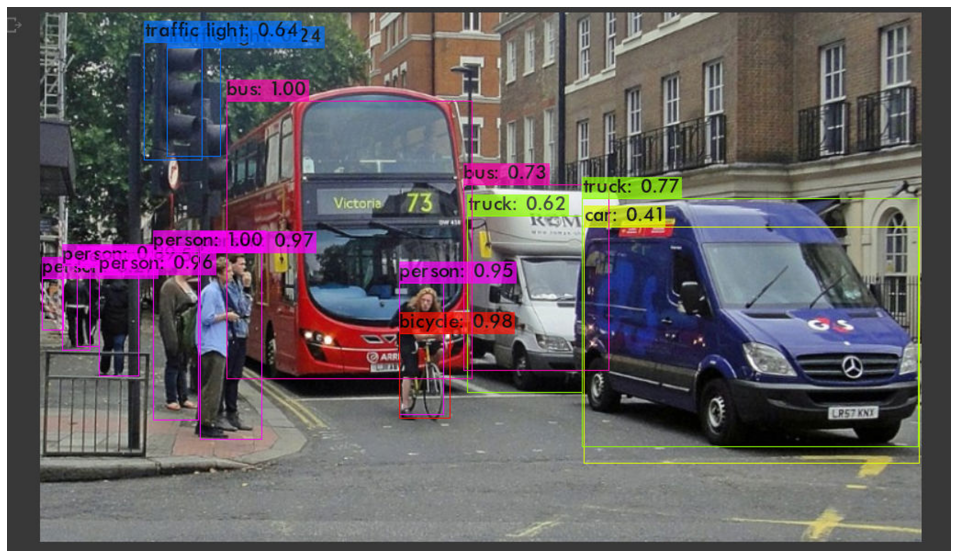

In [43]:
# Indorer to see the image_output

imShow('predictions.jpg')

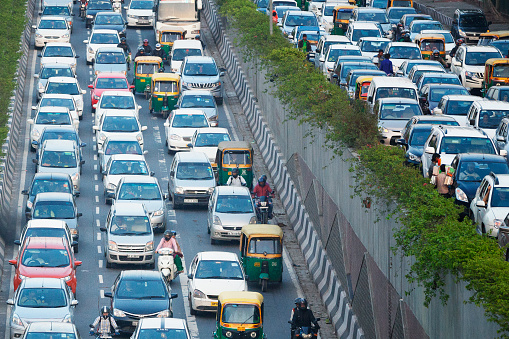

In [40]:
img = cv2.imread('/content/darknet/data/cars.jpg')
cv2_imshow(img)

In [ ]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/cars.jpg

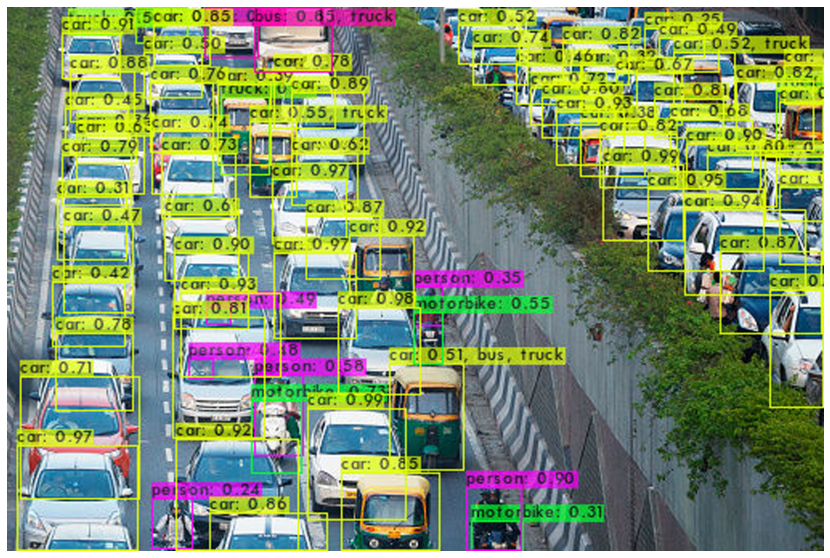

In [33]:
imShow('predictions.jpg')

# Step-4

## Enabling the webcam through google colab:

Accessing our webcam in Google Colab is not as straightforward. When we use Google Colab Runtime we have connected to a virtual machine. In order to utilize your local machine's webcam within the VM we can utilize JavaScript code.

We can find the JavaScript code in the code snipets.

This will open our local machine's webcam and we can capture an image and it will save our picture and test our object detection.

In [10]:

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


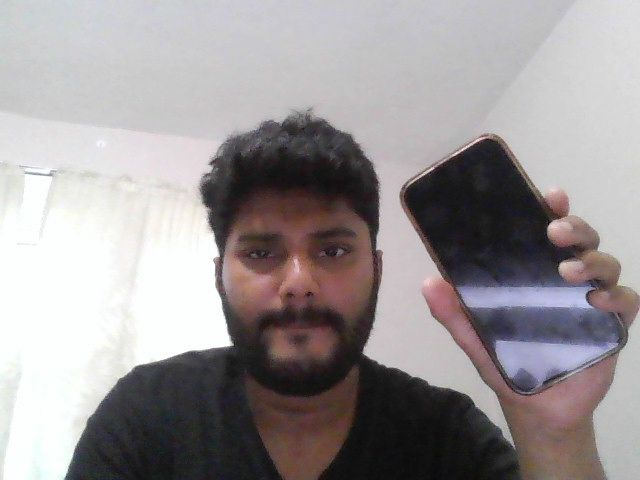

In [19]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
!./darknet detect cfg/yolov3.cfg yolov3.weights photo.jpg

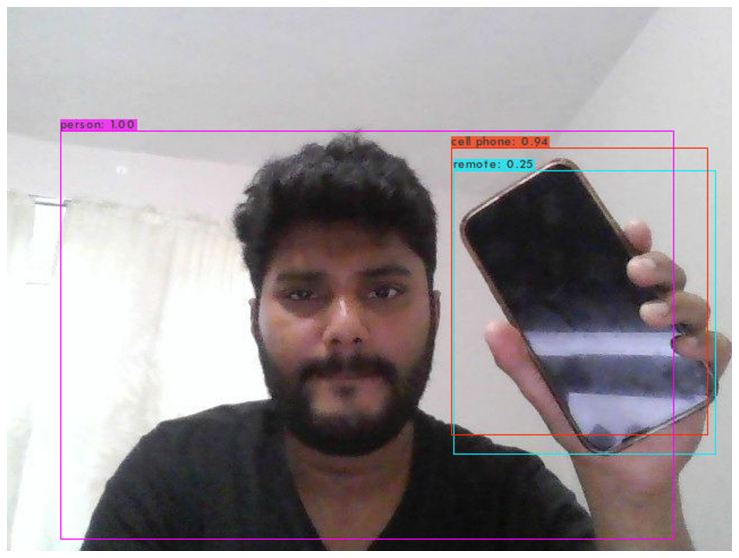

In [21]:
imShow('predictions.jpg')